# TlF ground state spectrum

Using the Hamiltonian from Table 1 of [D.A. Wilkening, N.F. Ramsey, and D.J. Larson, Phys Rev A **29**, 425 (1984)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.29.425).

![ramsey1](figs/ramsey1.png)

First import necessary Python packages, and define the constants.

In [1]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Units and constants

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

# TlF constants. Data from D.A. Wilkening, N.F. Ramsey,
# and D.J. Larson, Phys Rev A 29, 425 (1984). Everything in Hz.

Brot = 6689920000
c1 = 126030.0
c2 = 17890.0
c3 = 700.0
c4 = -13300.0

D_TlF = 4.2282 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]

# Constants from Wilkening et al, in Hz/Gauss, for 205Tl

mu_J = 35
mu_Tl = 1240.5
mu_F = 2003.63

### Representing the states

A state, in general, can be written as a weighted superposition of the basis states. We work in the basis $|J, m_J, I_1, m_1, I_2, m_2\rangle$.

The operations we can define on the basis states are:

- construction: e.g. calling `BasisState(QN)` creates a basis state with quantum numbers `QN = (J, mJ, I1, m1, I2, m2)`;
- equality testing;
- inner product, returning either 0 or 1;
- superposition and scalar multiplication, returning a `State` object
- a convenience function to print out all quantum numbers

In [3]:
class BasisState:
    # constructor
    def __init__(self, J, mJ, I1, m1, I2, m2):
        self.J, self.mJ  = J, mJ
        self.I1, self.m1 = I1, m1
        self.I2, self.m2 = I2, m2

    # equality testing
    def __eq__(self, other):
        return self.J==other.J and self.mJ==other.mJ \
                    and self.I1==other.I1 and self.I2==other.I2 \
                    and self.m1==other.m1 and self.m2==other.m2

    # inner product
    def __matmul__(self, other):
        if self == other:
            return 1
        else:
            return 0

    # superposition: addition
    def __add__(self, other):
        if self == other:
            return State([ (2,self) ])
        else:
            return State([ (1,self), (1,other) ])

    # superposition: subtraction
    def __sub__(self, other):
        return self + -1*other

    # scalar product (psi * a)
    def __mul__(self, a):
        return State([ (a, self) ])

    # scalar product (a * psi)
    def __rmul__(self, a):
        return self * a
    
    def print_quantum_numbers(self):
        print( self.J,"%+d"%self.mJ,"%+0.1f"%self.m1,"%+0.1f"%self.m2 )

A general state `State` can have any number of components, so let's represent it as an list of pairs `(amp, psi)`, where `amp` is the relative amplitude of a component, and `psi` is a basis state. The same component must not appear twice on the list.

There are three operations we can define on the states:

- construction
- superposition: concatenate component arrays and return a `State`
- scalar multiplication `a * psi` and `psi * a`, division, negation
- component-wise inner product `psi1 @ psi2`, where `psi1` is a bra, and `psi2` a ket, returning a complex number

In addition, I define an iterator method to loop through the components, and the `__getitem__()` method to access the components (which are not necessarily in any particular order!). See [Classes/Iterators](https://docs.python.org/3/tutorial/classes.html#iterators) for details.

In [4]:
class State:
    # constructor
    def __init__(self, data=[], remove_zero_amp_cpts=True):
        # check for duplicates
        for i in range(len(data)):
            amp1,cpt1 = data[i][0], data[i][1]
            for amp2,cpt2 in data[i+1:]:
                if cpt1 == cpt2:
                    raise AssertionError("duplicate components!")
        # remove components with zero amplitudes
        if remove_zero_amp_cpts:
            self.data = [(amp,cpt) for amp,cpt in data if amp!=0]
        else:
            self.data = data
        # for iteration over the State
        self.index = len(self.data)

    # superposition: addition
    # (highly inefficient and ugly but should work)
    def __add__(self, other):
        data = []
        # add components that are in self but not in other
        for amp1,cpt1 in self.data:
            only_in_self = True
            for amp2,cpt2 in other.data:
                if cpt2 == cpt1:
                    only_in_self = False
            if only_in_self:
                data.append((amp1,cpt1))
        # add components that are in other but not in self
        for amp1,cpt1 in other.data:
            only_in_other = True
            for amp2,cpt2 in self.data:
                if cpt2 == cpt1:
                    only_in_other = False
            if only_in_other:
                data.append((amp1,cpt1))
        # add components that are both in self and in other
        for amp1,cpt1 in self.data:
            for amp2,cpt2 in other.data:
                if cpt2 == cpt1:
                    data.append((amp1+amp2,cpt1))
        return State(data)
                
    # superposition: subtraction
    def __sub__(self, other):
        return self + -1*other

    # scalar product (psi * a)
    def __mul__(self, a):
        return State( [(a*amp,psi) for amp,psi in self.data] )

    # scalar product (a * psi)
    def __rmul__(self, a):
        return self * a
    
    # scalar division (psi / a)
    def __truediv__(self, a):
        return self * (1/a)
    
    # negation
    def __neg__(self):
        return -1.0 * self
    
    # inner product
    def __matmul__(self, other):
        result = 0
        for amp1,psi1 in self.data:
            for amp2,psi2 in other.data:
                result += amp1.conjugate()*amp2 * (psi1@psi2)
        return result

    # iterator methods
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.index == 0:
            raise StopIteration
        self.index -= 1
        return self.data[self.index]
    
    # direct access to a component
    def __getitem__(self, i):
        return self.data[i]

### Operators in Python

Define QM operators as Python functions that take `BasisState` objects, and return `State` objects. Since we are interested in finding matrix elements, we only need the action of operators on the basis states (but it'd be easy to generalize using a `for` loop).

The easiest operators to define are the diagonal ones $J^2, J_z, I_{1z}, I_{2z}$, which just multiply the state by their eigenvalue:

In [5]:
def J2(psi):
    return State([(psi.J*(psi.J+1),psi)])

def Jz(psi):
    return State([(psi.mJ,psi)])

def I1z(psi):
    return State([(psi.m1,psi)])

def I2z(psi):
    return State([(psi.m2,psi)])

The other angular momentum operators we can obtain through the ladder operators

$$ J_\pm=J_x\pm iJ_y. $$

These are defined through their action on the basis states as (Sakurai eqns 3.5.39-40)

$$ J_\pm|J,m\rangle=\sqrt{(j\mp m)(j\pm m+1)}|jm\pm1\rangle. $$

Similarly, $I_{1\pm},I_{2\pm}$ act on the $|I_1,m_1\rangle$ and $|I_2,m_2\rangle$ subspaces in the same way.

In [6]:
def Jp(psi):
    amp = sqrt((psi.J-psi.mJ)*(psi.J+psi.mJ+1))
    ket = BasisState(psi.J, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp,ket)])

def Jm(psi):
    amp = sqrt((psi.J+psi.mJ)*(psi.J-psi.mJ+1))
    ket = BasisState(psi.J, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I1p(psi):
    amp = sqrt((psi.I1-psi.m1)*(psi.I1+psi.m1+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1+1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I1m(psi):
    amp = sqrt((psi.I1+psi.m1)*(psi.I1-psi.m1+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1-1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I2p(psi):
    amp = sqrt((psi.I2-psi.m2)*(psi.I2+psi.m2+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2+1)
    return State([(amp,ket)])

def I2m(psi):
    amp = sqrt((psi.I2+psi.m2)*(psi.I2-psi.m2+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2-1)
    return State([(amp,ket)])

In terms of the above-defined ladder operators, we can write

$$J_x=\frac{1}{2}(J_++J_-);\quad
J_y=\frac{1}{2i}(J_+-J_-),$$

and similarly for $I_{1x}, I_{1y}$ and $I_{2x}, I_{2y}$.

In [7]:
def Jx(psi):
    return .5*( Jp(psi) + Jm(psi) )

def Jy(psi):
    return -.5j*( Jp(psi) - Jm(psi) )

def I1x(psi):
    return .5*( I1p(psi) + I1m(psi) )

def I1y(psi):
    return -.5j*( I1p(psi) - I1m(psi) )

def I2x(psi):
    return .5*( I2p(psi) + I2m(psi) )

def I2y(psi):
    return -.5j*( I2p(psi) - I2m(psi) )

### Composition of operators

All operators defined above can only accept `BasisStates` as their inputs, and they all return `States` as output. To allow composition of operators,

$$\hat A\hat B|\psi\rangle=\hat A(\hat B(|\psi\rangle)),$$

define the following function.

In [8]:
def com(A, B, psi):
    ABpsi = State()
    # operate with A on all components in B|psi>
    for amp,cpt in B(psi):
        ABpsi += amp * A(cpt)
    return ABpsi

### Rotational term

The simplest term in the Hamiltonian simply gives the rotational levels:

$$H_\text{rot}=B_\text{rot}\vec J^2.$$

In [9]:
def Hrot(psi):
    return Brot * J2(psi)

### Terms with ang. momentum dot products

Note that the dot product of two angular momentum operators can be written in terms of the ladder operators as

$$\vec A\cdot\vec B=A_zB_z+\frac{1}{2}(A_+B_-+A_-B_+).$$

We have the following terms (from Table 1 of Ramsey's paper):

$$
H_\text{c1}=c_1\vec I_1\cdot\vec J;\quad
H_\text{c2}=c_2\vec I_2\cdot\vec J;\quad
H_\text{c4}=c_4\vec I_1\cdot\vec I_2\\
H_\text{c3a}=15c_3\frac{(\vec I_1\cdot\vec J)(\vec I_2\cdot\vec J)}{(2J+3)(2J-1)}
=\frac{15c_3}{c_1c_2}\frac{H_\text{c1}H_\text{c2}}{(2J+3)(2J-1)}\\
H_\text{c3b}=15c_3\frac{(\vec I_2\cdot\vec J)(\vec I_1\cdot\vec J)}{(2J+3)(2J-1)}
=\frac{15c_3}{c_1c_2}\frac{H_\text{c2}H_\text{c1}}{(2J+3)(2J-1)}\\
H_\text{c3c}=-10c_3\frac{(\vec I_1\cdot\vec I_2)\vec J^2}{(2J+3)(2J-1)}
=\frac{-10c_3}{c_4 B_\text{rot}}\frac{H_\text{c4}H_\text{rot}}{(2J+3)(2J-1)}
$$

In [10]:
def Hc1(psi):
    return c1 * ( com(I1z,Jz,psi) + .5*(com(I1p,Jm,psi)+com(I1m,Jp,psi)) )

def Hc2(psi):
    return c2 * ( com(I2z,Jz,psi) + .5*(com(I2p,Jm,psi)+com(I2m,Jp,psi)) )

def Hc4(psi):
    return c4 * ( com(I1z,I2z,psi) + .5*(com(I1p,I2m,psi)+com(I1m,I2p,psi)) )

def Hc3a(psi):
    return 15*c3/c1/c2 * com(Hc1,Hc2,psi) / ((2*psi.J+3)*(2*psi.J-1))

def Hc3b(psi):
    return 15*c3/c1/c2 * com(Hc2,Hc1,psi) / ((2*psi.J+3)*(2*psi.J-1))

def Hc3c(psi):
    return -10*c3/c4/Brot * com(Hc4,Hrot,psi) / ((2*psi.J+3)*(2*psi.J-1))

The overall field-free Hamiltonian is

In [11]:
def Hff(psi):
    return Hrot(psi) + Hc1(psi) + Hc2(psi) + Hc3a(psi) + Hc3b(psi) \
            + Hc3c(psi) + Hc4(psi)

### Zeeman Hamiltonian

In order to separate the task of finding the matrix elements and the eigenvalues, the Hamiltonian

$$H^\text{Z}=-\frac{\mu_J}{J}(\vec J\cdot\vec B)-\frac{\mu_1}{I_1}(\vec I_1\cdot\vec B)-\frac{\mu_2}{I_2}(\vec I_2\cdot\vec B)$$

is best split into three matrices:

$$H^\text{Z}=B_xH^\text{Z}_x+B_yH^\text{Z}_y+B_zH^\text{Z}_z,$$

where

$$ H^\text{Z}_x = -\frac{\mu_J}{J}J_x -\frac{\mu_1}{I_1}I_{1x} -\frac{\mu_2}{I_2}I_{2x} $$
$$ H^\text{Z}_y = -\frac{\mu_J}{J}J_y -\frac{\mu_1}{I_1}I_{1y} -\frac{\mu_2}{I_2}I_{2y} $$
$$ H^\text{Z}_z = -\frac{\mu_J}{J}J_z -\frac{\mu_1}{I_1}I_{1z} -\frac{\mu_2}{I_2}I_{2z} $$

Note that we are using the convention $\mu_1=\mu_\text{Tl}$ and $\mu_2=\mu_\text{F}$. The terms involving division by $J$ are only valid for states with $J\ne0$ (of course!).

In [12]:
def HZx(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jx(psi) - mu_Tl/psi.I1*I1x(psi) - mu_F/psi.I2*I2x(psi)
    else:
        return -mu_Tl/psi.I1*I1x(psi) - mu_F/psi.I2*I2x(psi)

def HZy(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jy(psi) - mu_Tl/psi.I1*I1y(psi) - mu_F/psi.I2*I2y(psi)
    else:
        return -mu_Tl/psi.I1*I1y(psi) - mu_F/psi.I2*I2y(psi)
    
def HZz(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jz(psi) - mu_Tl/psi.I1*I1z(psi) - mu_F/psi.I2*I2z(psi)
    else:
        return -mu_Tl/psi.I1*I1z(psi) - mu_F/psi.I2*I2z(psi)

### Stark Hamiltonian

Again splitting the Hamiltonian into the three spatial components, we have

$$H^\text{S}=-\vec d\cdot\vec E
=E_xH^\text{S}_x+E_yH^\text{S}_y+E_zH^\text{S}_z.$$

To find the effect of the electric dipole operators (written in terms of the spherical harmonics)

$$\vec d
=d_\text{TlF}\begin{pmatrix}\hat d_x\\\hat d_y\\\hat d_z\end{pmatrix}
=d_\text{TlF}\begin{pmatrix}\sin\theta\cos\phi\\\sin\theta\sin\phi\\\cos\theta\end{pmatrix}
=d_\text{TlF}\sqrt{\frac{2\pi}{3}}\begin{pmatrix}
Y_1^{-1}-Y_1^1\\
i(Y_1^{-1}+Y_1^1)\\
\sqrt2Y_1^0\end{pmatrix}$$

on the eigenstates $|J,m,\ldots\rangle$, we need to find their matrix elements. The wavefunctions are $\langle\theta,\phi|J,m\rangle=Y_J^m$, so the matrix elements of the spherical harmonics are

$$
\langle J',m'|Y_1^M||J,m\rangle
=\int(Y_{J'}^{m'})^*Y_1^MY_J^md\Omega
=(-1)^{m}\int(Y_{J'}^{m'})^*(Y_1^{-M})^*Y_J^md\Omega.
$$

According to [Wikipedia](https://en.wikipedia.org/wiki/Clebsch%E2%80%93Gordan_coefficients#Relation_to_spherical_harmonics), this evaluates to

$$
\sqrt{\frac{2\pi}{3}}
\langle J',m'|Y_1^M||J,m\rangle
=(-1)^{M}
 \sqrt{\frac{(2 J' + 1)}{2(2 J + 1)}}
    \langle J' \, 0 \, 1 \, 0 | J \, 0 \rangle
    \langle J' \, m' \, 1 \, -M | J \, m \rangle
$$

This can be partially evaluated using the following Mathematica function:

```mathematica
coeffs[M_] := Table[(-1)^M Sqrt[(2 Jp + 1)/(2 (2 J + 1))]
     ClebschGordan[{Jp, mp}, {1, -M}, {J, m}]
     ClebschGordan[{Jp, 0}, {1, 0}, {J, 0}] // FullSimplify,
   {mp, {m - 1, m, m + 1}}, {Jp, {J - 1, J + 1}}
   ] // MatrixForm
```

The result for $M=0$ is nonzero for $m'=m$:

$$
\begin{aligned}
\sqrt{\frac{(J-m)(J+m)}{8J^2-2}}&\quad\text{for $J'=J-1$}\\
\sqrt{\frac{(J-m+1)(J+m+1)}{6+8J(J+2)}}&\quad\text{for $J'=J+1$}
\end{aligned}
$$

For $M=-1$, we need $m'=m-1$:

$$
\begin{aligned}
-\frac{1}{2}
\sqrt{\frac{(J+m)(J-1+m)}{4J^2-1}}&\quad\text{for $J'=J-1$}\\
\frac{1}{2}
\sqrt{\frac{(J+1-m)(J+2-m)}{3+4J(J+2)}}&\quad\text{for $J'=J+1$}
\end{aligned}
$$

For $M=1$, we need $m'=m+1$:

$$
\begin{aligned}
-\frac{1}{2}
\sqrt{\frac{(J-m)(J-1-m)}{4J^2-1}}&\quad\text{for $J'=J-1$}\\
\frac{1}{2}
\sqrt{\frac{(J+1+m)(J+2+m)}{3+4J(J+2)}}&\quad\text{for $J'=J+1$}
\end{aligned}
$$

These three cases can be written in Python as the operators:

In [13]:
def R10(psi):
    amp1 = np.sqrt(2)*sqrt((psi.J-psi.mJ)*(psi.J+psi.mJ)/(8*psi.J**2-2))
    ket1 = BasisState(psi.J-1, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = np.sqrt(2)*sqrt((psi.J-psi.mJ+1)*(psi.J+psi.mJ+1)/(6+8*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

def R1m(psi):
    amp1 = -.5*np.sqrt(2)*sqrt((psi.J+psi.mJ)*(psi.J+psi.mJ-1)/(4*psi.J**2-1))
    ket1 = BasisState(psi.J-1, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = .5*np.sqrt(2)*sqrt((psi.J-psi.mJ+1)*(psi.J-psi.mJ+2)/(3+4*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

def R1p(psi):
    amp1 = -.5*np.sqrt(2)*sqrt((psi.J-psi.mJ)*(psi.J-psi.mJ-1)/(4*psi.J**2-1))
    ket1 = BasisState(psi.J-1, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = .5*np.sqrt(2)*sqrt((psi.J+psi.mJ+1)*(psi.J+psi.mJ+2)/(3+4*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

In terms of the operators

$$
R^M_1\equiv2\sqrt{\frac{\pi}{3}}Y_1^M
$$

and the molecular dipole moment $d_\text{TlF}$, the three Stark Hamiltonians are

$$
\begin{align}
H^\text{S}_x&=-d_\text{TlF}(R^{-1}_1-R^1_1)/\sqrt{2}\\
H^\text{S}_y&=-d_\text{TlF}i(R^{-1}_1+R^1_1)/\sqrt{2}\\
H^\text{S}_z&=-d_\text{TlF}R^0_1
\end{align}
$$

In Python:

In [14]:
def HSx(psi):
    return -D_TlF * ( R1m(psi) - R1p(psi) )/sqrt(2)

def HSy(psi):
    return -D_TlF * 1j * ( R1m(psi) + R1p(psi) )/sqrt(2)

def HSz(psi):
    return -D_TlF * R10(psi)

### An alternative $c_3$ term

The $c_3$ term in Ramsey's Hamiltonian assumes that $J$ is a good quantum number, which breaks down at high $E$ field. From [Wikipedia](https://en.wikipedia.org/wiki/Hyperfine_structure#Molecular_hyperfine_structure), we get the term

$$
H_\text{c3}^\text{alt}=\frac{5}{2}c_3\left[
2\vec I_1\vec I_2
-3(\vec I_1\cdot\vec{\hat{R}})(\vec I_2\cdot\vec{\hat{R}})
-3(\vec I_2\cdot\vec{\hat{R}})(\vec I_1\cdot\vec{\hat{R}})
\right].
$$

Write the dot products in the form

$$
H_\text{I1R}=\vec I_1\cdot\vec{\hat{R}}=I_{1z}R_1^0+\frac{1}{\sqrt2}(I_{1+}R_1^{-1}-I_{1-}R_1^{1})\\
H_\text{I2R}=\vec I_2\cdot\vec{\hat{R}}=I_{2z}R_1^0+\frac{1}{\sqrt2}(I_{2+}R_1^{-1}-I_{2-}R_1^{1}),
$$

as follows:

In [15]:
def HI1R(psi):
    return com(I1z,R10,psi) + (com(I1p,R1m,psi)-com(I1m,R1p,psi))/sqrt(2)

def HI2R(psi):
    return com(I2z,R10,psi) + (com(I2p,R1m,psi)-com(I2m,R1p,psi))/sqrt(2)

The $c_3$ term becomes

$$
H_\text{c3}^\text{alt}=\frac{5}{2}c_3\left[
\frac{2}{c_4}H_\text{c4}-3H_\text{I1R}H_\text{I2R}-3H_\text{I2R}H_\text{I1R}
\right].
$$

In Python:

In [16]:
def Hc3_alt(psi):
    return 5*c3/c4*Hc4(psi) - 15*c3/2*(com(HI1R,HI2R,psi)+com(HI2R,HI1R,psi))

The corresponding alternative field-free Hamiltonian is

In [17]:
def Hff_alt(psi):
    return Hrot(psi) + Hc1(psi) + Hc2(psi) + Hc3_alt(psi) + Hc4(psi)

### Finding the matrix elements

With all the operators defined, we can evaluate the matrix elements for a given range of quantum numbers. Write down the basis as a list of `BasisState` components:

In [18]:
QN = np.array([BasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J in range(Jmax+1)
      for mJ in range(-J,J+1)
      for m1 in np.arange(-I_Tl,I_Tl+1)
      for m2 in np.arange(-I_F,I_F+1)])

The field-free and Stark/Zeeman components of the Hamiltonian then have the matrix elements

In [19]:
result = np.empty((8,len(QN),len(QN)), dtype=complex)
for i,a in enumerate(tqdm(QN)):
    for j,b in enumerate(QN):
        for k,H in enumerate([Hff, HSx, HSy, HSz, HZx, HZy, HZz, Hff_alt]):
            result[k,i,j] = (1*a)@H(b)

Hff_m, HSx_m, HSy_m, HSz_m, HZx_m, HZy_m, HZz_m, Hff_alt_m = result

Write/read the Hamiltonians to/from files:

In [20]:
# for i,x in enumerate(result):
#     np.savetxt(f"data/H6-{i}.csv", x)

Hff_m, HSx_m, HSy_m, HSz_m, HZx_m, HZy_m, HZz_m, Hff_alt_m = \
    [np.loadtxt(f"data/H6-{i}.csv", dtype='complex128') for i in range(8)]

### Find the energies

Above, we have evaluated the matrix elements for the zero-field Hamiltonian $H_\text{ff}$, as well as the $\vec E=1=\vec B$ cases. For general fields $\vec E,\vec B$, the Hamiltonian is

$$
H=H_\text{ff}
+
\begin{pmatrix}
E_x\\E_y\\E_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{S}_x\\H^\text{S}_y\\H^\text{S}_z
\end{pmatrix}
+
\begin{pmatrix}
B_x\\B_y\\B_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{Z}_x\\H^\text{Z}_y\\H^\text{Z}_z
\end{pmatrix}.
$$

When looking at the Zeeman/Stark effects on the hyperfine structure, the rotational structure is not of interest, so I subtract it for clarity in the following `spectrum()` function. It evaluates the above Hamiltonian for each point on the array of fields, and returns a list of energy levels, sorted by size:

In [21]:
def spectrum(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr, Hff_matrix=Hff_alt_m):
    energies_arr = []
    for Ex,Ey,Ez,Bx,By,Bz in zip(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
        HamE = Hff_matrix + \
            Ex*HSx_m  + Ey*HSy_m + Ez*HSz_m + \
            Bx*HZx_m  + By*HZy_m + Bz*HZz_m
        D = np.sort(np.linalg.eigvalsh(HamE))
        
        # Subtract away rotational energy for easier viewing of substructure
        hfs_mat = []
        for i,psi in enumerate(QN):
            hfs_mat.append(D[i] - psi.J*(psi.J +1)*Brot)
        hfs_kHz = np.array(hfs_mat)/1000

        energies_arr.append(hfs_kHz)
    return np.array(energies_arr)

def spectrum2(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr, Hff_matrix=Hff_alt_m):
    hfs_kHz = []
    for Ex,Ey,Ez,Bx,By,Bz in zip(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
        HamE = Hff_matrix + \
            Ex*HSx_m  + Ey*HSy_m + Ez*HSz_m + \
            Bx*HZx_m  + By*HZy_m + Bz*HZz_m
        hfs_kHz.append(1e-3 * np.sort(np.linalg.eigvalsh(HamE)))
    return np.array(hfs_kHz)

### Test 1: Reproducing Ramsey's Fig. 4

That's how it's supposed to look at 18.4 gauss of $B_z$:

![ramsey4](figs/ramsey4.png)

Evaluate find the energies for $B_z$ of 18.4 gauss, and $E_z$ between 0 and 70 V/cm, and plot the result:

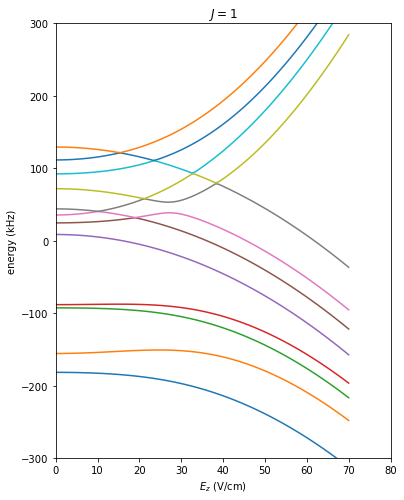

In [22]:
Ez = np.linspace(0,70,100)
Bz = 18.4 * np.ones(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

energies = spectrum(Ex,Ey,Ez,Bx,By,Bz)

for i in range(4,16):
    plt.plot(Ez, energies.T[i])
    
plt.title("$J=1$")
plt.xlabel("$E_z$ (V/cm)")
plt.ylabel("energy (kHz)")

plt.xlim([0,80])
plt.ylim([-300,300])

fig = plt.gcf()
fig.set_size_inches(6, 8)
plt.show()

Now plot the $J=2$ states:

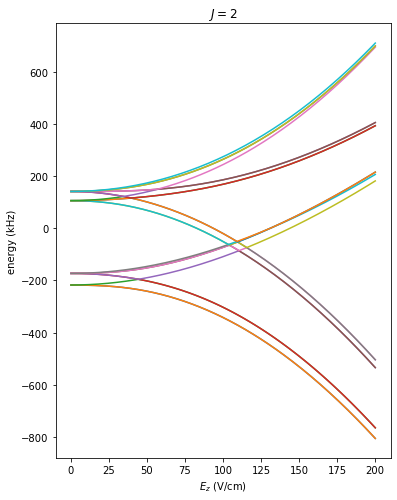

In [23]:
Ez = np.linspace(0,200,200)
Bz = np.zeros(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

energies = spectrum(Ex,Ey,Ez,Bx,By,Bz)

for i in range(16,36):
    plt.plot(Ez, energies.T[i])
    
plt.title("$J=2$")
plt.xlabel("$E_z$ (V/cm)")
plt.ylabel("energy (kHz)")

# plt.xlim([0,80])
# plt.ylim([-300,300])

fig = plt.gcf()
fig.set_size_inches(6, 8)
plt.show()

### Test 2: Rotating the fields

We have seen that the $z$ components of electric and magnetic field reproduce Ramsey's result. (They also match the energy levels calculated by Dave DeMille's Matlab code modulo a typo in his `c3` term.)

We should be able to get the same energy levels if we rotate both the electric and the magnetic field by the same angle. Define the rotation matrices:

In [24]:
def Rx(theta):
    return np.array([[1,0,0],
                     [0,np.cos(theta),-np.sin(theta)],
                     [0,np.sin(theta),np.cos(theta)]])

def Ry(theta):
    return np.array([[np.cos(theta),0,np.sin(theta)],
                     [0,1,0],
                     [-np.sin(theta),0,np.cos(theta)]])

def Rz(theta):
    return np.array([[np.cos(theta),-np.sin(theta),0],
                     [np.sin(theta),np.cos(theta),0],
                     [0,0,1]])

Start with a constant $B_x$ and a varying $E_x$. Calculate the energies:

In [25]:
Ex = np.linspace(0,70,100)
Ey = np.zeros(Ex.shape)
Ez = np.zeros(Ex.shape)

Bx = 18.4*np.ones(Ez.shape)
By = np.zeros(Ex.shape)
Bz = np.zeros(Ex.shape)

energies0 = spectrum(Ex,Ey,Ez,Bx,By,Bz)

Rotate both fields by $R_y(\theta)R_z(\phi)$ and calculate the energy difference:

In [26]:
print("theta\t phi\t delta")

for theta in np.pi/180*np.linspace(10,99,4):
    for phi in np.pi/180*np.linspace(10,99,4):
        # rotate fields
        Exr,Eyr,Ezr = Ry(theta)@Rz(phi)@np.array([Ex,Ey,Ez])
        Bxr,Byr,Bzr = Ry(theta)@Rz(phi)@np.array([Bx,By,Bz])

        # calculate energy difference
        energies1 = spectrum(Exr,Eyr,Ezr,Bxr,Byr,Bzr)
        print("%0.2f" % (theta*180/np.pi),
              "\t", "%0.2f" % (phi*180/np.pi),
              "\t", "%0.3E" % np.sum(energies0-energies1))

theta	 phi	 delta
10.00 	 10.00 	 -1.481E-05
10.00 	 39.67 	 -5.051E-05
10.00 	 69.33 	 -7.471E-05
10.00 	 99.00 	 -3.123E-05
39.67 	 10.00 	 -5.227E-06
39.67 	 39.67 	 7.724E-05
39.67 	 69.33 	 -2.584E-05
39.67 	 99.00 	 -1.160E-05
69.33 	 10.00 	 -3.221E-05
69.33 	 39.67 	 -5.964E-05
69.33 	 69.33 	 -6.122E-06
69.33 	 99.00 	 -2.577E-05
99.00 	 10.00 	 -1.058E-04
99.00 	 39.67 	 -2.328E-05
99.00 	 69.33 	 -5.393E-05
99.00 	 99.00 	 4.919E-06


### Identifying the eigenstates

We can also obtain the eigenvectors corresponding to the energies, which allows us to extract the quantum numbers corresponding to each energy level.

The function `eigenstates()` will return the energies and eigenstates (as an array of `State` objects) at a given EM field strength, ignoring components with amplitudes less than `epsilon`. Note that the amplitudes of the components of the eigenstates will lose all phase information to facilitate sorting. Unlike `spectrum()`, which takes arrays of field strength, `eigenstates()` only accepts a single field strength.

In [27]:
def eigenstates(Ex,Ey,Ez,Bx,By,Bz,epsilon=1e-6):
    # diagonalize the Hamiltonian
    H = Hff_m \
        + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m \
        + Bx*HZx_m + By*HZy_m + Bz*HZz_m
    eigvals,eigvecs = np.linalg.eigh(H)
    
    # find the quantum numbers of the largest-|amplitude| components
    states = []
    for eigvec in eigvecs.T:
        # normalize the largest |amplitude| to 1
        eigvec = eigvec / np.max(np.abs(eigvec))
        # find indices of the largest-|amplitude| components
        major = np.abs(eigvec) > epsilon
        
        # collect the major components into a State
        eigenstate = State()
        for amp,psi in zip(eigvec[major], QN[major]):
            eigenstate += amp * psi

        # sort the components by decreasing |amplitude|
        amps = np.array(eigenstate.data).T[0]
        cpts = np.array(eigenstate.data).T[1]
        cpts = cpts[np.argsort(np.abs(amps))]
        amps = amps[np.argsort(np.abs(amps))]
        sorted_state = State( data=np.array((amps,cpts)).T )
        states.append(sorted_state)
        
    return eigvals, np.array(states)

The convenience function `major_eigenstates()` prints out the energies and quantum numbers for a specified $J$ (by default, for $J=1$), ignoring components less than `epsilon` (by default, `epsilon=.95`).

Note that $J$ is determined simply from the order of energies, i.e. $J=0$ corresponds to the first four states, instead of through the eigenvector's components. This is convenient at high fields, where $J$ ceases to be a good quantum number but can still be used to identify the states in an asymptotic sense.

Similarly, `largest_eigenstate()` prints out a table of energies and quantum numbers, for only a single component for each eigenstate.

In [28]:
def largest_eigenstate(Ex,Ey,Ez,Bx,By,Bz,J=1,epsilon=.95):
    energies, states = eigenstates(Ex,Ey,Ez,Bx,By,Bz,epsilon=epsilon)
    print("i\tE [kHz]\t J mJ  m1   m2\n-------------------------------")
    for i in reversed(np.arange((2*I_Tl+1)*(2*I_F+1)*J**2,(2*I_Tl+1)*(2*I_F+1)*(J+1)*(J+1))):
        print(str(i)+"\t%+0.2f" % ((energies[int(i)]-J*(J+1)*Brot)/1e3), end='\t ')
        states[int(i)][0][1].print_quantum_numbers()
        
def major_eigenstates(Ex,Ey,Ez,Bx,By,Bz,J=1,epsilon=.95):
    energies, states = eigenstates(Ex,Ey,Ez,Bx,By,Bz,epsilon=epsilon)
    for i in reversed(np.arange((2*I_Tl+1)*(2*I_F+1)*J**2,(2*I_Tl+1)*(2*I_F+1)*(J+1)*(J+1))):
        print("("+str(i)+") E = %+0.16e" % ((energies[int(i)]-J*(J+1)*Brot)/1e3),"kHz",end='\n')
        for amp,psi in states[int(i)]:
            print("\t%+0.3f"%np.real(amp),"%+0.3fi"%np.imag(amp), end=' ')
            psi.print_quantum_numbers()

### Test 3: Low-field state identification

The $J=1$ levels (with applied fields) will have the quantum numbers as given in Ramsey's Table 2:

![ramsey2](figs/ramsey2a.png)

The function `largest_eigenstate()` defined above can be used to obtain the same prediction:

In [29]:
largest_eigenstate(0,0,70,0,0,18.4,J=1)

i	E [kHz]	 J mJ  m1   m2
-------------------------------
15.0	+401.16	 1 +0 -0.5 -0.5
14.0	+364.60	 1 +0 +0.5 -0.5
13.0	+334.26	 1 +0 -0.5 +0.5
12.0	+284.15	 1 +0 +0.5 +0.5
11.0	-36.60	 1 -1 -0.5 -0.5
10.0	-95.30	 1 +1 +0.5 -0.5
9.0	-121.72	 1 -1 -0.5 +0.5
8.0	-157.27	 1 +1 +0.5 +0.5
7.0	-196.39	 1 +1 -0.5 -0.5
6.0	-216.56	 1 -1 +0.5 -0.5
5.0	-247.92	 1 +1 -0.5 +0.5
4.0	-312.48	 1 -1 +0.5 +0.5


Print a table of field-free eigenstates:

In [30]:
for J in range(6):
    print("=============================")
    print("J =", J, "   amp    J  mJ  m1  m2 ")
    print("=============================")
    major_eigenstates(0,0,0,0,0,0,J,epsilon=.1)
    print("\n")

J = 0    amp    J  mJ  m1  m2 
(3.0) E = +9.9749999999999996e+00 kHz
	+1.000 +0.000i 0 +0 +0.5 -0.5
	-1.000 +0.000i 0 +0 -0.5 +0.5
(2.0) E = -3.3250000000000002e+00 kHz
	+1.000 +0.000i 0 +0 +0.5 +0.5
(1.0) E = -3.3250000000000002e+00 kHz
	-1.000 +0.000i 0 +0 +0.5 -0.5
	-1.000 +0.000i 0 +0 -0.5 +0.5
(0.0) E = -3.3250000000000002e+00 kHz
	+1.000 +0.000i 0 +0 -0.5 -0.5


J = 1    amp    J  mJ  m1  m2 
(15.0) E = +6.8985000003814690e+01 kHz
	-1.000 +0.000i 1 +0 -0.5 +0.5
	-1.000 +0.000i 1 +0 +0.5 -0.5
	-0.707 +0.000i 1 -1 +0.5 +0.5
	-0.707 +0.000i 1 +1 -0.5 -0.5
(14.0) E = +6.8985000001907352e+01 kHz
	-1.000 +0.000i 1 +0 -0.5 -0.5
	-0.707 +0.000i 1 -1 -0.5 +0.5
	-0.707 +0.000i 1 -1 +0.5 -0.5
(13.0) E = +6.8984999999999999e+01 kHz
	+1.000 +0.000i 1 +1 +0.5 +0.5
(12.0) E = +6.8984999999999999e+01 kHz
	+1.000 +0.000i 1 +0 +0.5 +0.5
	+0.707 +0.000i 1 +1 -0.5 +0.5
	+0.707 +0.000i 1 +1 +0.5 -0.5
(11.0) E = +6.8984999999999999e+01 kHz
	+1.000 +0.000i 1 -1 -0.5 -0.5
(10.0) E = +5.4446217386245728e

(99.0) E = +2.8515136364746093e+02 kHz
	-1.000 +0.000i 4 -1 -0.5 -0.5
	-0.707 +0.000i 4 -2 -0.5 +0.5
	-0.707 +0.000i 4 -2 +0.5 -0.5
	-0.378 +0.000i 4 -3 +0.5 +0.5
(98.0) E = +2.8515136363220216e+02 kHz
	+1.000 +0.000i 4 +4 +0.5 +0.5
(97.0) E = +2.8515136363220216e+02 kHz
	+1.000 +0.000i 4 +3 +0.5 +0.5
	+0.354 +0.000i 4 +4 +0.5 -0.5
	+0.354 +0.000i 4 +4 -0.5 +0.5
(96.0) E = +2.8515136363220216e+02 kHz
	-1.000 +0.000i 4 +0 +0.5 -0.5
	-1.000 +0.000i 4 +0 -0.5 +0.5
	-0.894 +0.000i 4 +1 -0.5 -0.5
	-0.894 +0.000i 4 -1 +0.5 +0.5
(95.0) E = +2.8515136363220216e+02 kHz
	+1.000 +0.000i 4 -3 -0.5 -0.5
	+0.354 +0.000i 4 -4 -0.5 +0.5
	+0.354 +0.000i 4 -4 +0.5 -0.5
(94.0) E = +2.8515136363220216e+02 kHz
	+1.000 +0.000i 4 +1 +0.5 +0.5
	+0.707 +0.000i 4 +2 +0.5 -0.5
	+0.707 +0.000i 4 +2 -0.5 +0.5
	+0.378 +0.000i 4 +3 -0.5 -0.5
(93.0) E = +2.8515136363220216e+02 kHz
	+1.000 +0.000i 4 -4 -0.5 -0.5
(92.0) E = +2.8515136363220216e+02 kHz
	-1.000 +0.000i 4 -2 -0.5 -0.5
	-0.535 +0.000i 4 -3 -0.5 +0.5
	-0.53

	+0.786 +0.000i 5 +1 +0.5 +0.5
	-0.728 +0.000i 5 +3 -0.5 -0.5
	+0.406 +0.000i 5 +2 +0.5 -0.5
	+0.238 +0.000i 5 +1 -0.5 +0.5
	-0.228 +0.000i 5 +0 +0.5 +0.5
	+0.220 +0.000i 5 +2 -0.5 -0.5
	-0.155 +0.000i 5 +1 +0.5 -0.5
	-0.116 +0.000i 5 -1 +0.5 +0.5
	+0.116 +0.000i 5 +1 -0.5 -0.5
(112.0) E = -3.3286197634887696e+02 kHz
	-1.000 +0.000i 5 -1 +0.5 +0.5
	+1.000 +0.000i 5 +1 -0.5 -0.5
	+0.864 +0.000i 5 +0 -0.5 +0.5
	-0.864 +0.000i 5 +0 +0.5 -0.5
	+0.234 +0.000i 5 +2 -0.5 +0.5
	-0.184 +0.000i 5 +1 +0.5 +0.5
	+0.180 +0.000i 5 +1 -0.5 +0.5
	-0.172 +0.000i 5 +0 +0.5 +0.5
	+0.170 +0.000i 5 +3 -0.5 -0.5
	+0.167 +0.000i 5 +2 -0.5 -0.5
	-0.117 +0.000i 5 +1 +0.5 -0.5
(111.0) E = -3.3286197634887696e+02 kHz
	-1.000 +0.000i 5 -5 +0.5 -0.5
	+0.325 +0.000i 5 -4 -0.5 -0.5
(110.0) E = -3.3286197634887696e+02 kHz
	-1.000 +0.000i 5 -1 +0.5 -0.5
	+0.956 +0.000i 5 +0 -0.5 -0.5
	-0.923 +0.000i 5 -2 +0.5 +0.5
	+0.651 +0.000i 5 -1 -0.5 +0.5
(109.0) E = -3.3286197640991213e+02 kHz
	-1.000 +0.000i 5 -4 +0.5 -0.5
	+0

### Test 4: Polarization

Define a function that returns the expectation value of the molecular dipole operator for a range of states at some given value of external fields, which is proportional to the polarization of the molecule:

In [31]:
def polarization(Ex,Ey,Ez,Bx,By,Bz):
    # diagonalize the Hamiltonian
    H = Hff_m \
        + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m \
        + Bx*HZx_m + By*HZy_m + Bz*HZz_m
    eigvals,eigvecs = np.linalg.eigh(H)
    
    # find expectation of d_z = HSz in all eigenstates
    exp_d = []
    for i in range(len(eigvecs)):
        psi = eigvecs[:, i]
        exp_d.append(np.real(-psi@HSz_m@psi/D_TlF))
    
    return np.array(exp_d)

Plot the polarization for a few of the familiar states:

In [32]:
Ez_arr = np.linspace(0,50e3,100)
P_arr = np.array([polarization(0,0,Ez,0,0,0) for Ez in tqdm(Ez_arr)])

np.savetxt("data/P_arr.csv", np.real(P_arr))
np.savetxt("data/Ez_arr.csv", np.real(Ez_arr))

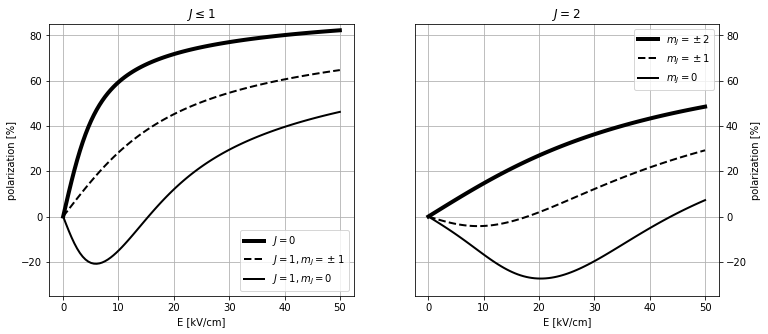

In [33]:
fig, axx = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axx[0].plot(Ez_arr/1e3, 100*P_arr[:,0],  color="black", lw=4, label="$J=0$")
axx[0].plot(Ez_arr/1e3, 100*P_arr[:,4],  color="black", lw=2, ls="--", label="$J=1, m_J=\pm1$")
axx[0].plot(Ez_arr/1e3, 100*P_arr[:,12], color="black", lw=2, ls="-", label="$J=1, m_J=0$")

axx[1].plot(Ez_arr/1e3, 100*P_arr[:,16],  color="black", lw=4, label="$m_J=\pm2$")
axx[1].plot(Ez_arr/1e3, 100*P_arr[:,24],  color="black", lw=2, ls="--", label="$m_J=\pm1$")
axx[1].plot(Ez_arr/1e3, 100*P_arr[:,32], color="black", lw=2, ls="-", label="$m_J=0$")
 
for i in range(2):
    axx[i].grid()
    axx[i].set_xlabel("E [kV/cm]")
    axx[i].set_ylabel("polarization [%]")
    axx[i].legend()
    axx[i].set_ylim((-35,85))
    
axx[0].set_title("$J \leq 1$")
axx[1].set_title("$J = 2$")

axx[1].yaxis.set_label_position("right")
axx[1].yaxis.tick_right();

### Test 5: High-field state identification

At high fields, the rotational angular momentum $J$ is no longer a good quantum number, but we can still use it in an asymptotic sense to identify the 4th through 15th lowest eigenstate. Consider Fig. 7 and Table 1 of Hinds's paper:

[Cho, Donghyun, K. Sangster, and E. A. Hinds. "Search for time-reversal-symmetry violation in thallium fluoride using a jet source." Physical Review A **44**, no. 5 (1991): 2783.](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.44.2783)

![](figs/hinds17.png)

The above plot is readily reproduced:

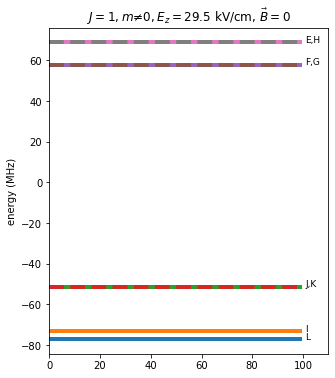

In [34]:
energies, _ = eigenstates(0,0,29.5e3,0,0,0,epsilon=.95)

energies /= 1e3
epsilon = 1e-3
En = np.ones(100)
mean = np.mean(energies[4:12])
labels = ["L","I","J,K",1,"F,G",1,"E,H"]
for i,E in enumerate(energies[4:12]):
    if np.abs(E-energies[4+i-1]) < epsilon:
        plt.plot(E*En-mean, lw=4, ls='dashed')
    else:
        plt.plot(E*En-mean, lw=4)
        plt.text(101,E-mean,labels[i],fontsize=9)
plt.title(r"$J=1, m\ne0, E_z=29.5$ kV/cm, $\vec B=0$")
plt.ylabel("energy (MHz)")
plt.xlim([0,110])
fig = plt.gcf()
fig.set_size_inches(5, 6)
plt.show()

As explained in the figure's caption in the paper, the pairs (E, H), (F, G), and (J, K) are degenerate doublets, while I and L are split. The function `major_eigenstates()` can give the eigencomponents of these energy levels:

In [35]:
major_eigenstates(0,0,30e3,0,0,10e-6,J=1,epsilon=.9)

(15.0) E = -9.2662558915431786e+05 kHz
	+1.000 +0.000i 2 +0 +0.5 -0.5
	-1.000 +0.000i 2 +0 -0.5 +0.5
(14.0) E = -9.2663824004149251e+05 kHz
	-1.000 +0.000i 2 +0 -0.5 +0.5
	-1.000 +0.000i 2 +0 +0.5 -0.5
(13.0) E = -9.2663921363267140e+05 kHz
	+1.000 +0.000i 2 +0 -0.5 -0.5
(12.0) E = -9.2663921369762614e+05 kHz
	+1.000 +0.000i 2 +0 +0.5 +0.5
(11.0) E = -2.1893113097437970e+07 kHz
	+1.000 +0.000i 1 -1 -0.5 -0.5
(10.0) E = -2.1893113097503453e+07 kHz
	-1.000 +0.000i 1 +1 +0.5 +0.5
(9.0) E = -2.1893124123680979e+07 kHz
	+1.000 +0.000i 1 +1 +0.5 -0.5
(8.0) E = -2.1893124123695578e+07 kHz
	-1.000 +0.000i 1 -1 -0.5 +0.5
(7.0) E = -2.1893233103874587e+07 kHz
	+1.000 +0.000i 1 -1 +0.5 -0.5
(6.0) E = -2.1893233103890337e+07 kHz
	-1.000 +0.000i 1 +1 -0.5 +0.5
(5.0) E = -2.1893255164361943e+07 kHz
	-1.000 +0.000i 1 +1 -0.5 -0.5
	-1.000 +0.000i 1 -1 +0.5 +0.5
(4.0) E = -2.1893258870563779e+07 kHz
	+1.000 +0.000i 1 -1 +0.5 +0.5
	-1.000 +0.000i 1 +1 -0.5 -0.5


These states plotted in the above graph match the states in Ed Hinds's Table 1. Note that $J$ is no longer a good quantum number.

The state pairs `eh`, `fg`, and `jk` are degenerate at $B=0$ and $E_z=30$ kV/cm. To map between the Hinds labels, and the ordering of eigenvalues, we note that at 30kV/cm, the ordering of the degenerate states depends on the Zeeman shift, linear for magnetic field along the electric field, and quadratic otherwise. We thus have two sets of order-label maps:

In [36]:
labels_Bz_pos = {'a':14, 'b':15, 'c':12, 'd':13, 'e':11, 'f':9, 'g':8, 'h':10, 'i':5, 'j':7, 'k':6, 'l':4,}
labels_Bz_neg = {'a':13, 'b':15, 'c':12, 'd':14, 'e':10, 'f':8, 'g':9, 'h':11, 'i':5, 'j':6, 'k':7, 'l':4,}

### Test 6: Sensitivity of C resonance to residual fields

The two states in the C resonance are E and J according to Ramsey's terminology, with $(m_J,m_1,m_2)=(-1,\mp1/2,-1/2)$. The slope of the resonance is roughly as stated in the Ramsey paper (but not Hinds --- he likely has a wrong number, copied from Ramsey rather than calculated / measured correctly), albeit we have to use the new `c3` term and not the one Ramsey quotes in his paper:

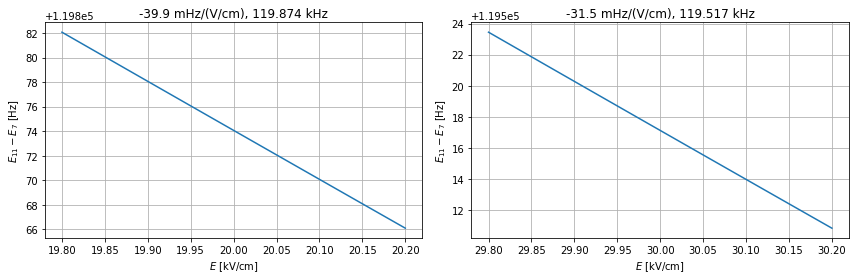

In [64]:
i1, i2 = labels_Bz_pos['e'], labels_Bz_pos['j']
Hff_matrix=Hff_alt_m

fig, axx = plt.subplots(ncols=2, figsize=(12,4))
for i,E0 in enumerate([20e3, 30e3]):
    # electric fields
    dE = 0.2e3
    E1, E2 = E0-dE, E0+dE
    Ez_arr = np.linspace(E1, E2, 25)

    # eigenenergies and slopes
    E_arr = spectrum(0*Ez_arr,0*Ez_arr,Ez_arr,0*Ez_arr,0*Ez_arr,0*Ez_arr+10e-6, Hff_matrix)
    slope = -1e6*((E_arr[0,i1]-E_arr[0,i2])-(E_arr[-1,i1]-E_arr[-1,i2]))/(E2-E1)
    f0 = E_arr[len(E_arr)//2,i1] - E_arr[len(E_arr)//2,i2]
    
    # plot
    axx[i].plot(Ez_arr/1e3, 1e3*(E_arr[:,i1] - E_arr[:,i2]))
    axx[i].set_title(str(round(slope,2))+" mHz/(V/cm), "+str(round(f0,3))+" kHz")
    axx[i].set_xlabel("$E$ [kV/cm]")
    axx[i].set_ylabel("$E_{"+str(i1)+"}-E_{"+str(i2)+"}$ [Hz]")
    axx[i].grid();
    
plt.tight_layout()

Note how the slope flattens out as the field increases:

In [38]:
# field parameters
E1, E2 = 2e3, 100e3
Ez_arr = np.linspace(E1, E2, 200)

# transition labels and indices
t_lab = [['e', 'j'], ['e', 'g'], ['f', 'j']]
t_num = [[labels_Bz_pos[i] for i in x] for x in t_lab]

# calculate slopes
slope = [Ez_arr[:-1]/1e3]
for i1, i2 in t_num:
    for Hff_matrix in [Hff_alt_m, Hff_m]:
        E_arr = spectrum(0*Ez_arr,0*Ez_arr,Ez_arr,0*Ez_arr,0*Ez_arr,0*Ez_arr+10e-6, Hff_matrix)
        slope.append(-1e6*np.diff(E_arr[:,i1]-E_arr[:,i2])/(Ez_arr[1]-Ez_arr[0]))
        
# save to file
np.savetxt("data/slope.csv", slope)

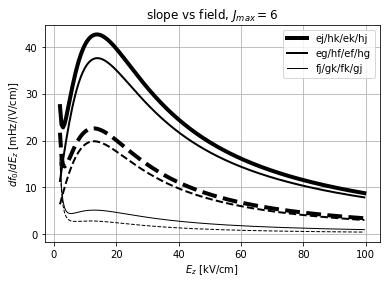

In [39]:
# load data
slope = np.loadtxt("data/slope.csv")
labels = 2*["ej/hk/ek/hj", "eg/hf/ef/hg", "fj/gk/fk/gj", ]
lw_list = [4,2,1]

# plot data
for i in range(3):
    # new c3 term
    plt.plot(slope[0], slope[2*i+1], color="black", label=labels[i], lw=lw_list[i])
    
    # old c3 term
    plt.plot(slope[0], slope[2*i+2], color="black", ls='--', lw=lw_list[i])

# plot labels
plt.title("slope vs field, $J_{max}=6$")
plt.xlabel("$E_z$ [kV/cm]")
plt.ylabel("$df_0/dE_z$ [mHz/(V/cm)]")
plt.legend()

# plot format
plt.grid()

The approx. 50G internal magnetic field can be exactly reversed by flipping the sign of $m_J$. For example, in zero external magnetic field, the separation between states `e` & `j` (with $m_J=-1$) should be equal to that between states `h` & `k` (with $m_J=+1$), but a residual field in the interaction region would remove the degeneracy.

In [71]:
# field parameters
E0 = 30e3
B0, dB = 1e-6, 9e-6
Bz_arr = np.linspace(B0, B0+dB, 250)

# transition parameters
labels = [['e', 'j', 'h', 'k'], ['e', 'k', 'h', 'j'], ['f', 'j', 'g', 'k'], 
          ['f', 'k', 'g', 'j'], ['e', 'g', 'h', 'f'], ['e', 'f', 'h', 'g'], ]
numbers = [[labels_Bz_pos[i] for i in x] for x in labels]
# numbers = [[10,7,11,6], [10,9,11,8], [10,8,11,9],    [10,6,11,7], [8,7,9,6], [8,6,9,7],  ]
spins  = ["$m_{Tl}$",  "$m_J,m_F$",     "$m_J,$", "$m_{Tl},m_F$", "$m_F$",   "$m_{J},m_F$"]

# calculate data
ee = spectrum2(0*Bz_arr,0*Bz_arr,0*Bz_arr+E0,0*Bz_arr,0*Bz_arr,Bz_arr, Hff_matrix=Hff_alt_m)

# plot data
all_B_slopes = [Bz_arr]
for (i1,i2,i3,i4),l in zip(numbers,spins):
    s = (ee[:,i1]-ee[:,i2]) - (ee[:,i3]-ee[:,i4])
    all_B_slopes.append(s)
    
    # printout numerical values
    dsdB = (s[-1]-s[0]) / (Bz_arr[-1]-Bz_arr[0])
    print(l, "\t", round(dsdB,2))
    
# save data to file
np.savetxt("data/all_B_slopes.csv", all_B_slopes)

$m_{Tl}$ 	 5.0
$m_J,m_F$ 	 8.09
$m_J,$ 	 -0.06
$m_{Tl},m_F$ 	 3.02
$m_F$ 	 8.02
$m_{J},m_F$ 	 5.07


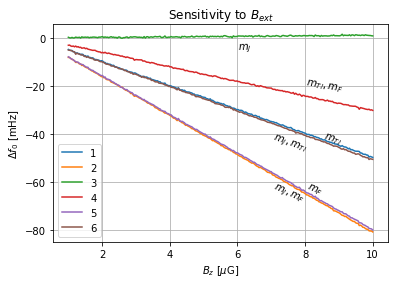

In [61]:
# load data
s = np.loadtxt("data/all_B_slopes.csv")
lw_list = [4,2,1]
lw_list = [1.5,         1.5,         1.5,            1.5,           1.5,       1.5]
ls_list = ["solid",    "solid",     "solid",       "solid",     "solid",  "solid"]
labels  = ["$m_J,m_F$","$m_F$",     "$m_J,m_{Tl}$", "$m_{Tl}$", "$m_{Tl},m_F$",   "$m_J$"]
y_list  = [-68,         -65,         -47,            -44,         -22,       -5]
angles  = [-25,         -25,         -20,            -20,         -10,       1]
x_list  = [7,           8,           7,              8.5,           8,         6]

# setup axes
fig, ax1 = plt.subplots()
ax1.grid()

# plot data
for i in range(6):
    ax1.plot(1e6*s[0], -1e6*s[i+1], label=i+1, lw=lw_list[i], ls=ls_list[i])#, color="black")

# plot labels
ax1.set_title("Sensitivity to $B_{ext}$")
ax1.set_xlabel("$B_z$ [$\mu$G]")
ax1.set_ylabel("$\Delta f_0$ [mHz]")
for x,y,l,a in zip(x_list,y_list,labels,angles):
    plt.text(x,y,l,rotation=a)
plt.legend()

Calculate matrix elements of $I_{z,\text{Tl}}$:

In [43]:
I1z_m = np.empty((len(QN),len(QN)), dtype=complex)
for i,a in enumerate(QN):
    for j,b in enumerate(QN):
            I1z_m[i,j] = (1*a)@I1z(b)

The above plots show that some transitions are better than others. However, they do not say much about whether these transitions are allowed (nonzero Zeeman matrix element between the two states), or sensitive to the T-violating physics (difference in the expectation value of thallium spin between the two states). Now calculate these quantities:

In [44]:
i_arr = [[10,7],[11,6],[10,6],[11,7],[8,7],[9,6],[8,6],[9,7],[10,9],[11,8],[10,8],[11,9]]
Ez = 30e3

print("i \t j   ME_x      ME_y      ME_z    SMt sens.")

eigvals,eigvecs = np.linalg.eigh(Hff_alt_m+Ez*HSz_m)
for i,j in i_arr:
    # calculate matrix elements
    ME_x = np.abs(eigvecs[:,i]@HZx_m@eigvecs[:,j])
    ME_y = np.abs(eigvecs[:,i]@HZy_m@eigvecs[:,j])
    ME_z = np.abs(eigvecs[:,i]@HZz_m@eigvecs[:,j])
    SMt  = np.abs(eigvecs[:,i]@I1z_m@eigvecs[:,i] - eigvecs[:,j]@I1z_m@eigvecs[:,j])
    
    # print values
    print(i, "\t", j, " ", '%07.2f'%ME_x, " ", '%07.2f'%ME_y, " ", '%05.2f'%ME_z, " ", '%03.2f'%SMt)

i 	 j   ME_x      ME_y      ME_z    SMt sens.
10 	 7   1328.84   1328.84   00.00   0.95
11 	 6   1328.84   1328.84   00.00   0.95
10 	 6   0282.15   0282.15   00.00   0.04
11 	 7   0282.15   0282.15   00.00   0.04
8 	 7   0000.00   0000.00   00.00   0.00
9 	 6   0000.00   0000.00   00.00   0.00
8 	 6   0000.00   0000.00   91.40   0.99
9 	 7   0000.00   0000.00   91.40   0.99
10 	 9   1883.61   1883.61   00.00   0.04
11 	 8   1883.61   1883.61   00.00   0.04
10 	 8   0399.94   0399.94   00.00   0.95
11 	 9   0399.94   0399.94   00.00   0.95


Due to molecular motion through the large constant electric field, they experience the motional magnetic field

$$
\vec B_\text{mot}=\vec E\times\vec v/c^2.
$$

Despite the fact that $\vec B_\text{mot}$ reverses with the $E$ field, it is perpendicular to the applied electric field, resulting in a quadratic, $E$-even frequency shift. However, there might still be a linear shift due to the presence of a residual magnetic field in the interaction region along the direction of $\vec E$. The residual field, assumed constant, and the reversing motional field, form a sum and difference (depending on the sign of $E$) of different magnitudes, and thus a second-order shift that despite being quadratic depends on the sign of $E$.

For molecules moving at 180 m/s in the 30 kV/cm field, the motional magnetic field is 60 μG perpendicular to the $E$ field. Let's plot the shift resonant frequencies between the two orientations of the electric field, as a function of the residual field.

In [239]:
# field parameters
Bres = np.linspace(1e-6,50e-3,250)
Bmot = 60e-6
Ez = 30e3
i1, i2 = 11, 7

# transition parameters
labels = [['e', 'j'], ['h', 'k'], ['e', 'k'], ['h', 'j'], ['j', 'f'], ['k', 'g'], 
          ['k', 'f'], ['j', 'g'], ['e', 'g'], ['h', 'f'], ['e', 'f'], ['h', 'g'], ]
numbers = [[labels_Bz_pos[i] for i in x] for x in labels]

# diagonalize the Hamiltonian
ee1 = spectrum2(0*Bres,0*Bres,0*Bres+Ez,0*Bres,Bres+Bmot,0*Bres, Hff_matrix=Hff_alt_m)
ee2 = spectrum2(0*Bres,0*Bres,0*Bres-Ez,0*Bres,Bres-Bmot,0*Bres, Hff_matrix=Hff_alt_m)

# calculate slopes
Bmot_data = [Bres]
for i, ((i1,i2), (l1,l2)) in enumerate(zip(numbers, labels)):
    diff = (ee1[:,i1]-ee1[:,i2]) - (ee2[:,i1]-ee2[:,i2])
    Bmot_data.append(diff)

# save to file
np.savetxt("data/Bmot_data.csv", Bmot_data)

[0.04597901 0.02294752]


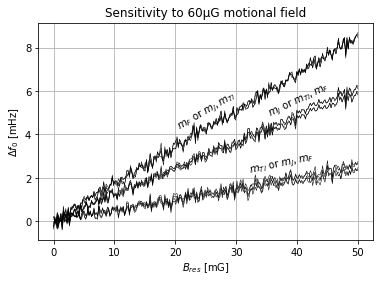

In [240]:
from scipy.signal import savgol_filter

# load from file
data = np.loadtxt("data/Bmot_data.csv")

# plot data
for i,d in enumerate(data[1:]):
    plt.plot(1e3*data[0], 1e6*d, color='black', lw=.5)
    
# fit straight line
fp = np.polyfit(1e3*data[0], 1e6*data[1], 1)
print(fp)

# plot labels
plt.ylabel("$Δf_0$ [mHz]")
plt.xlabel("$B_{res}$ [mG]")
plt.title("Sensitivity to 60μG motional field")
plt.text(20,4.25,"$m_{F}$ or $m_J,m_{Tl}$",rotation=30)
plt.text(35,4.85,"$m_J$ or $m_{Tl},m_{F}$",rotation=25)
plt.text(32,2.25,"$m_{Tl}$ or $m_J,m_{F}$",rotation=12)

# plot format
plt.grid()
plt.show()